In [1]:
import numpy as np
import pandas as pd 

In [2]:
data = np.loadtxt("../data/logisticRegressionCircular.txt",delimiter = ",")

In [3]:
x = data[:,:2]
y = data[:,2]

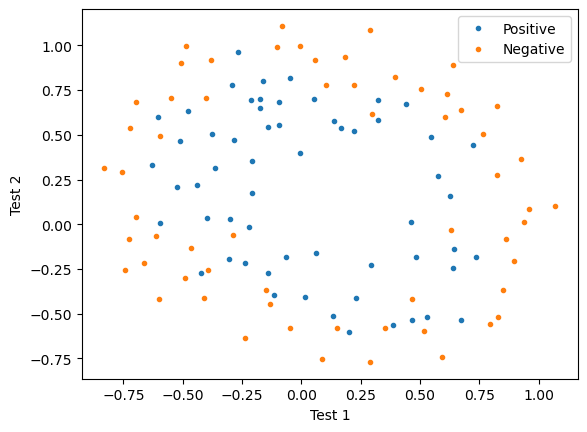

In [4]:
# 2D PLOT
import matplotlib.pyplot as plt

%matplotlib inline
plt.clf()  # clear the figure

positive = y == 1
negative = y == 0

plt.plot(x[positive, 0], x[positive, 1], '.', label="Positive")
plt.plot(x[negative, 0], x[negative, 1], '.', label="Negative")

plt.ylabel('Test 2') 
plt.xlabel('Test 1') 
plt.legend(loc="upper right")
plt.show()


In [5]:
'''
#alternate

# x_values_transformed is going to have one extra column which is the bias. You can remove it manually
 
bias -> first column (default - 1)
(or)

setting 'include_bias' = False

poly = PolynomialFeatures(degree=6,include_bias=False)

-------
from sklearn.preprocessing import PolynomialFeatures

#transforming the features using polynomial features
poly = PolynomialFeatures(degree=6)
x_values_transformed = poly.fit_transform(x)

#get output feature names for transformation
print(poly.get_feature_names_out(input_features=None))

--
for example, for degree = 4 :
x0 -> feature 1, x1 -> feature 2, bias -> include_bias=False (no bias)
['x0' 'x1' 'x0^2' 'x0 x1' 'x1^2' 'x0^3' 'x0^2 x1' 'x0 x1^2' 'x1^3' 'x0^4'
 'x0^3 x1' 'x0^2 x1^2' 'x0 x1^3' 'x1^4']
--
print(x_values_transformed.shape)
'''
def map_feature(x1, x2, degree=6):
    x1 = np.atleast_1d(x1)
    x2 = np.atleast_1d(x2)
    output = []
    for i in range(1, degree+1):
        for j in range(i + 1):
            output.append((x1**(i-j) * (x2**j)))
    return np.stack(output, axis=1)

In [6]:
mapped_x =  map_feature(x[:, 0], x[:, 1],6)

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.activations import sigmoid


In [8]:
print("Before Normalization: (max, min)")
print(f"x1: ({np.max(mapped_x[:,0]):0.2f}, {np.min(mapped_x[:,0]):0.2f})")
print(f"x2: ({np.max(mapped_x[:,1]):0.2f}, {np.min(mapped_x[:,1]):0.2f})\n")

#axis = 1 -> normalize feature-wise 
norm_layer = tf.keras.layers.Normalization(axis=1)
norm_layer.adapt(mapped_x) # learns mean, variance
x_normalized = norm_layer(mapped_x) #passing the data x through the normalized layer

print("After Normalization: (max, min)")
print(f"x1: ({np.max(x_normalized[:,0]):0.2f}, {np.min(x_normalized[:,0]):0.2f})")
print(f"x2: ({np.max(x_normalized[:,1]):0.2f}, {np.min(x_normalized[:,1]):0.2f})")

Before Normalization: (max, min)
x1: (1.07, -0.83)
x2: (1.11, -0.77)

After Normalization: (max, min)
x1: (2.05, -1.79)
x2: (1.79, -1.84)


In [9]:
#repeats an array along specified dimensions to create repetitions.


"""
tiling our data to replicate our data, 
thereby increasing the sample size for better model training.

increasing epochs can help your model learn better but only up to a point, beyond which overfitting might occur. Data augmentation, 
such as tiling, helps improve model generalization.
"""


print(f"Before tiling:\nx_normalized: {x_normalized.shape}, y:{y.shape}\n")
Xt = np.tile(x_normalized,(1000,1))

Yt= np.tile(y.reshape(-1,1),(1000,1))   
print(f"After tiling:\nXt:{Xt.shape}, Yt:{Yt.shape}")   


Before tiling:
x_normalized: (118, 27), y:(118,)

After tiling:
Xt:(118000, 27), Yt:(118000, 1)


In [10]:
# Set seed for reproducibility, ensuring "random" numbers are predictable
tf.random.set_seed(15)

model = Sequential(
    [
        # Input layer to specify expected shape of the input data, (27,) in this case
        # Input: array of 27 No.s (after mapped)
        tf.keras.Input(shape=(27,)),
        Dense(3, activation='sigmoid', name = 'layer1'),
        Dense(1, activation='sigmoid', name = 'layer2')
     ]
)


In [11]:

'''
Each Parameter: 32 bit (Single Precision Floating Points) -> 4 bytes
Size: 4 bytes * 88 = 352 Bytes

Input Shape: (27,)

layer1: 
3 neurons
27 * 3 = 81 weights

Each Neuron has a bias : 3 * 1 = 3 biases

81 + 3 = 84 parameters

layer2:
activation vector from layer1: (3,)
1 neuron

3 * 1 = 3 weights
Each Neuron has a bias : 1 * 1 = 1 bias

3 + 1 = 4 parameters

TOTAL: 84 parameters + 4 parameters = 88 parameters

'''

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 3)                 84        
                                                                 
 layer2 (Dense)              (None, 1)                 4         
                                                                 
Total params: 88 (352.00 Byte)
Trainable params: 88 (352.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
'''
Weights: (no. of features in input, no. of neurons in the layer)
Bias: no. of neurons in a layer

layer1: 3 neurons, 2 inputs -> Weights: (2,3)
layer2: 1 neuron, 3 inputs -> Weights: (3,1)
'''

W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print(f"W1 {W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1,"\n")
print(f"W2 {W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1 (27, 3):
 [[-0.15093154 -0.34254995  0.40804952]
 [-0.21796553 -0.38569623  0.1395281 ]
 [ 0.23728997  0.08584458 -0.36332   ]
 [-0.31910908  0.01103047 -0.15357316]
 [-0.2636307   0.22949052 -0.28499418]
 [ 0.11010629  0.3356486  -0.09220216]
 [ 0.10293007  0.00641716 -0.4146924 ]
 [-0.0310469  -0.13031492  0.04577976]
 [ 0.01350617 -0.12983555  0.11733204]
 [ 0.15200609  0.20294201  0.2529782 ]
 [ 0.15223908  0.07408011 -0.07822236]
 [-0.36604562 -0.09762603 -0.09858298]
 [ 0.05748367  0.3430519   0.24925447]
 [ 0.2419123  -0.04012391 -0.17926827]
 [ 0.2162221   0.26991332 -0.05015126]
 [ 0.3642972  -0.0382407  -0.02995676]
 [ 0.02752829  0.24786258  0.39444846]
 [-0.10379016  0.38472837 -0.42066655]
 [-0.07993305  0.3513863  -0.24783625]
 [-0.2053325   0.43212587  0.2743771 ]
 [-0.25989544 -0.04881334 -0.35982487]
 [-0.39126667 -0.06900889  0.21238261]
 [ 0.2426216   0.18635035 -0.28009877]
 [ 0.39773697  0.1251781   0.41319788]
 [ 0.430391   -0.1469985  -0.14790887]
 [-0.0586834

In [13]:
#batch-size
import math
#default batch-size in keras -> 32 rows

math.ceil(Xt.shape[0]/32)

3688

In [14]:
#Apple Silicon: optimizers.legacy.Adam
#Base: optimizers.Adam

#BinaryCrossentropy() -> BCE -> Logistic Loss Func -> -ylog(y') - (1-y)log(1-y')
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.3),
)

model.fit(
    Xt,Yt,            
    epochs=10,
)

Epoch 1/10
3688/3688 [==============================] - 2s 410us/step - loss: 0.2814
Epoch 2/10
3688/3688 [==============================] - 1s 396us/step - loss: 0.2686
Epoch 3/10
3688/3688 [==============================] - 1s 401us/step - loss: 0.2679
Epoch 4/10
3688/3688 [==============================] - 1s 397us/step - loss: 0.2839
Epoch 5/10
3688/3688 [==============================] - 1s 402us/step - loss: 0.2853
Epoch 6/10
3688/3688 [==============================] - 1s 398us/step - loss: 0.2732
Epoch 7/10
3688/3688 [==============================] - 1s 393us/step - loss: 0.2612
Epoch 8/10
3688/3688 [==============================] - 1s 401us/step - loss: 0.2873
Epoch 9/10
3688/3688 [==============================] - 1s 396us/step - loss: 0.3224
Epoch 10/10
3688/3688 [==============================] - 1s 399us/step - loss: 0.3135


In [15]:

W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print(f"W1 {W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1,"\n")
print(f"W2 {W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1 (27, 3):
 [[-40.613102   -59.48573    -14.866917  ]
 [-28.586859   -41.518967   -30.219666  ]
 [ 72.090385   -16.615753    31.010513  ]
 [ 55.888912   106.5571      11.487733  ]
 [  8.827176    70.59133     43.39231   ]
 [ 19.718044   -24.615784   -24.985239  ]
 [-76.59873    -37.546566     9.100145  ]
 [ 37.711018   -22.671242   -11.31743   ]
 [-23.485271   -18.27206    -19.461166  ]
 [ 57.97096     27.084166    49.435867  ]
 [ -5.507338    41.32314    -10.429392  ]
 [ 17.686865    41.24873     17.046696  ]
 [ 29.3567     -14.6856785   10.818789  ]
 [ 23.556255    37.54494     41.179947  ]
 [ 30.308233    12.22377    -11.815801  ]
 [-50.395042    35.56231     23.390518  ]
 [ 41.0557     -72.26867     -2.4791002 ]
 [ -4.6532755  -17.422874     0.69970495]
 [ 57.8005     121.37663      7.279094  ]
 [-25.48206    -25.09451      2.1953237 ]
 [ 44.293674    67.09897     45.460938  ]
 [-61.446682   -29.340107     1.2750133 ]
 [ 28.611734    42.36916     50.736485  ]
 [-50.88255    -44.53

In [16]:
x_test = np.array([[0.051267,0.69956]])

# mapping the features
mapped_x_test = map_feature(x_test[:, 0], x_test[:, 1],6)

# normalizing the features
x_test_normalized = norm_layer(mapped_x_test)

print(x_test_normalized)

# reshaping using tf.reshape if necessary (the model expects input to have a certain shape)
x_test_normalized = tf.reshape(x_test_normalized, (1, -1))
# getting the prediction
y_pred = model.predict(x_test_normalized)

print(f"The model prediction for {x_test} is {y_pred[0][0]}")


tf.Tensor(
[[-0.0071013   0.99791807 -0.98977673  0.274898    0.6635931  -0.21829255
  -0.21502961  0.06425668  0.6158709  -0.5880131   0.05549109 -0.7235762
   0.24604157  0.2439574  -0.24294192 -0.16406117 -0.17240581 -0.29825962
   0.08229139  0.17403954 -0.40598637  0.01211625 -0.5542344   0.04696623
  -0.50738925  0.16502519 -0.02886213]], shape=(1, 27), dtype=float32)
1/1 [==============================] - 0s 35ms/step
The model prediction for [[0.051267 0.69956 ]] is 0.9627996683120728


In [17]:
'''
#alternate (not recommended)

array = np.array([])
for m in range(x_normalized.shape[0]):
    y_pred = model.predict(np.reshape(x_normalized[m], (1, -1)))
    array = np.append(array, y_pred)
#reshape array to match the shape of y
array = array.reshape(-1, 1)
'''
array = model.predict(x_normalized)
#thresholding the probabilities
array_predictions = (array >= 0.5).astype(int)

#calculating accuracy
accuracy = np.mean(array_predictions == y.reshape(-1, 1)) * 100
print('Accuracy: %f' % accuracy)


4/4 [==============================] - 0s 753us/step
Accuracy: 88.135593


In [18]:
from tensorflow.keras.models import Model

# creating a new model that's identical to the original model up to the first layer
intermediate_model = Model(inputs=model.input, outputs=model.get_layer("layer1").output)

# for a given input x_normalized, activations of the first layer
first_layer_activations = intermediate_model.predict(x_normalized)


4/4 [==============================] - 0s 801us/step


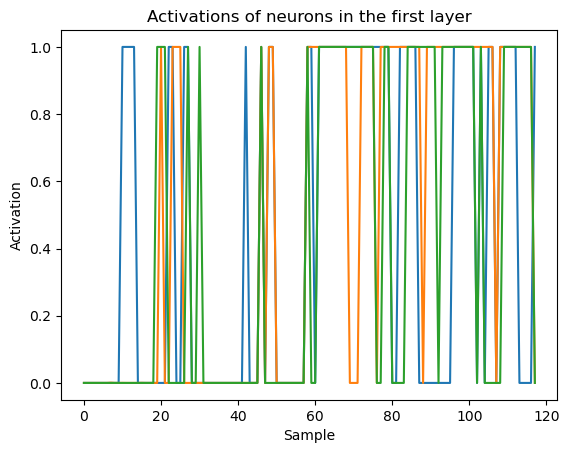

In [19]:
import matplotlib.pyplot as plt

# plotting the activations of each neuron
for i in range(first_layer_activations.shape[1]):
    plt.plot(first_layer_activations[:, i])

plt.title('Activations of neurons in the first layer')
plt.xlabel('Sample')
plt.ylabel('Activation')
#plt.legend(['Neuron 1', 'Neuron 2', 'Neuron 3'], loc='upper right')
plt.show()


4/4 [==============================] - 0s 752us/step


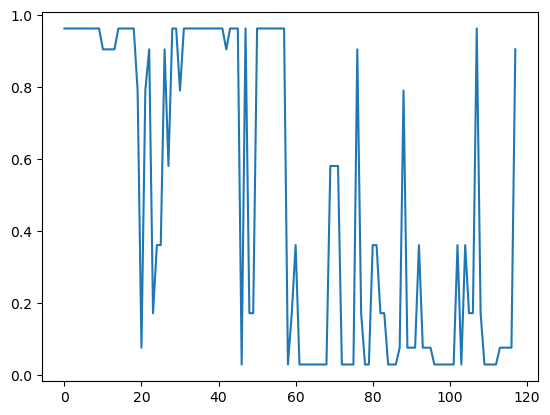

In [20]:
from keras.models import Model

# intermediate model that outputs the activations of the second layer
intermediate_model = Model(inputs=model.input, outputs=model.get_layer("layer2").output)

intermediate_output = intermediate_model.predict(x_normalized)

plt.plot(intermediate_output)
plt.show()


In [21]:
#implementing simple neural network

'''
if you multiply sigmoid(x) by e^x/e^x
sigmoid(x) = 1 / (1 + np.exp(-x)) = exp(x) / (exp(x) + 1); 

- to avoid exponent overflow in some cases (clipping is more ideal)
'''
def sigmoid(x):
    x = np.clip(x, -50, 50) 
    # clipping the values to be within the range of -50 to 50 to avoid overflow
    return 1 / (1 + np.exp(-x))


In [22]:
def dense_layer(activation_input, w_values,b_values):
    """
    activation_input: (n,) -> reshape to (1,n)
    w_values: (n,m) -> n features per neuron, m neurons 
    b_values: (m,) -> bias vector of m units -> reshape to (1,m)
    
    activation_output: (1,m)
    
    activation_input @ w_values -> (1,n) X (n,m) = (1,m)
   """
    activation_output = sigmoid(activation_input.reshape(1,-1) @ w_values + b_values.reshape(1,-1))
    return(activation_output)
    

In [23]:
def sequential_model(X, W1, b1, w2, b2):
    a1 = dense_layer(X,  W1, b1)
    a2 = dense_layer(a1, W2, b2)
    return(a2)

In [24]:
def model_predict(X, W1, b1, W2, b2):
    m = X.shape[0] # input = (27,)
    p = np.zeros(m)
    for i in range(m):
        p[i] = sequential_model(X[i], W1, b1, W2, b2)[0,0]
    return(p)

In [25]:
x_test = np.array([[0.051267,0.69956]])

# mapping the features
mapped_x_test = map_feature(x_test[:, 0], x_test[:, 1],6)

# normalizing the features
x_test_normalized = norm_layer(mapped_x_test)


print(x_test_normalized)

print(x_test_normalized.shape)

prediction = model_predict(np.array(x_test_normalized),W1,b1,W2,b2)


tf.Tensor(
[[-0.0071013   0.99791807 -0.98977673  0.274898    0.6635931  -0.21829255
  -0.21502961  0.06425668  0.6158709  -0.5880131   0.05549109 -0.7235762
   0.24604157  0.2439574  -0.24294192 -0.16406117 -0.17240581 -0.29825962
   0.08229139  0.17403954 -0.40598637  0.01211625 -0.5542344   0.04696623
  -0.50738925  0.16502519 -0.02886213]], shape=(1, 27), dtype=float32)
(1, 27)


In [26]:
dataset_pred = model_predict(np.array(x_normalized),W1,b1,W2,b2)
print(x_normalized.shape)
print(W1.shape)
print(dataset_pred.shape)

(118, 27)
(27, 3)
(118,)


In [27]:
dataset_accuracy = np.mean(dataset_pred == y.reshape(-1, 1)) * 100
print('Accuracy: %f' % accuracy)

Accuracy: 88.135593


1250/1250 [==============================] - 0s 290us/step


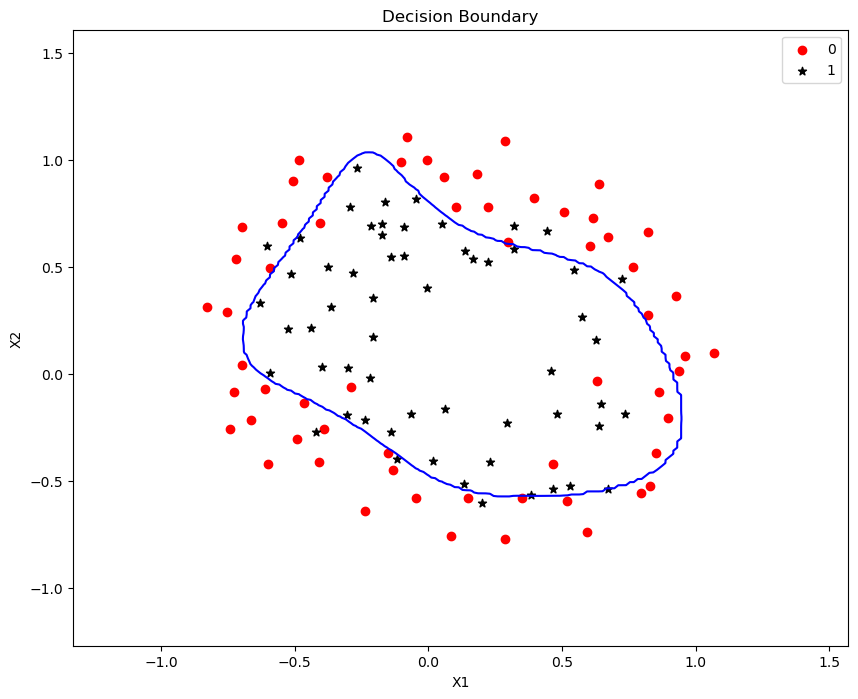

In [28]:
x1_min, x1_max = np.min(mapped_x[:,0]) - 0.5, np.max(mapped_x[:,0]) + 0.5
x2_min, x2_max = np.min(mapped_x[:,1]) - 0.5, np.max(mapped_x[:,1]) + 0.5

x1_values = np.linspace(x1_min, x1_max, 200)
x2_values = np.linspace(x2_min, x2_max, 200)

#meshgrid
x1, x2 = np.meshgrid(x1_values, x2_values)

# flattening x1 and x2 to create X_test array
X_test = np.column_stack((x1.ravel(), x2.ravel()))

# transforming X_test using map_feature function and the normalization layer
mapped_X_test = map_feature(X_test[:, 0], X_test[:, 1], 6)
normalized_X_test = norm_layer(mapped_X_test)

# using the model to predict the class of each point in the grid
Y_pred = model.predict(normalized_X_test)
# reshaping Y_pred to match the shape of the x1 and x2
Y_pred = Y_pred.reshape(x1.shape)


# Create a contour plot to show the decision boundary
plt.figure(figsize=(10, 8))
plt.contour(x1, x2, Y_pred, levels=[0.5], colors='b')  # decision boundary at p = 0.5
plt.scatter(x[y == 0, 0], x[y == 0, 1], marker='o', c='r', label="0")
plt.scatter(x[y == 1, 0], x[y == 1, 1], marker='*', c='black', label="1")
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.title('Decision Boundary')
plt.show()


In [29]:
'''
exploring meshgrid and ravel
'''
va1s = np.linspace(1, 10, 4)
va2s = np.linspace(1, 10, 4)

v1, v2 = np.meshgrid(va1s, va2s)
print("v1:",v1,"v2:",v2,sep='\n')

print("\nv1 ravel:",v1.ravel())
print("v2 ravel:",v2.ravel())
lmno = np.column_stack((v1.ravel(),v2.ravel()))
print("\ncolumn stack:\n",lmno)

v1:
[[ 1.  4.  7. 10.]
 [ 1.  4.  7. 10.]
 [ 1.  4.  7. 10.]
 [ 1.  4.  7. 10.]]
v2:
[[ 1.  1.  1.  1.]
 [ 4.  4.  4.  4.]
 [ 7.  7.  7.  7.]
 [10. 10. 10. 10.]]

v1 ravel: [ 1.  4.  7. 10.  1.  4.  7. 10.  1.  4.  7. 10.  1.  4.  7. 10.]
v2 ravel: [ 1.  1.  1.  1.  4.  4.  4.  4.  7.  7.  7.  7. 10. 10. 10. 10.]

column stack:
 [[ 1.  1.]
 [ 4.  1.]
 [ 7.  1.]
 [10.  1.]
 [ 1.  4.]
 [ 4.  4.]
 [ 7.  4.]
 [10.  4.]
 [ 1.  7.]
 [ 4.  7.]
 [ 7.  7.]
 [10.  7.]
 [ 1. 10.]
 [ 4. 10.]
 [ 7. 10.]
 [10. 10.]]


interactive(children=(IntSlider(value=30, description='elev', max=90, step=10), IntSlider(value=120, descripti…

<function __main__.update(elev=30, azim=120)>

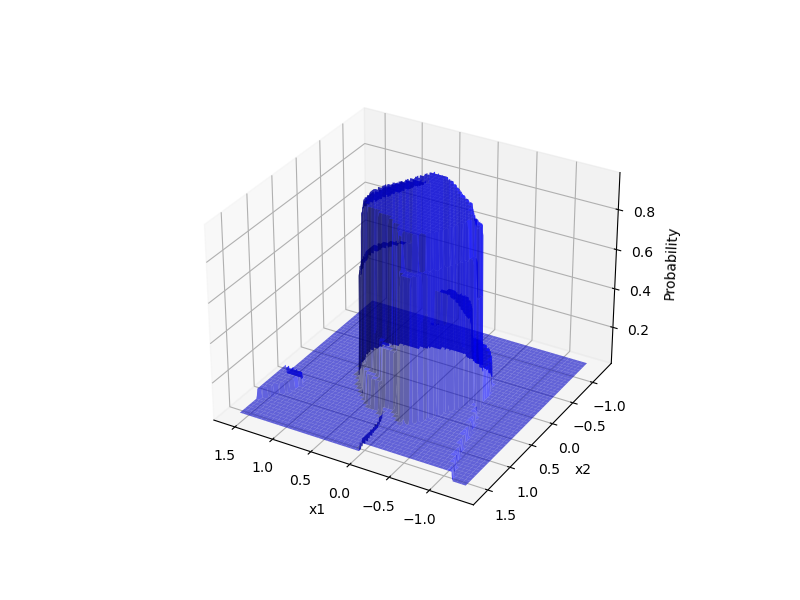

In [30]:
%matplotlib widget
'''
!pip install ipywidgets
!pip install ipympl

'''
#3D Plot
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1, x2, Y_pred, color='b', alpha=0.6)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('Probability')

def update(elev=30, azim=120):
    ax.view_init(elev, azim)
    plt.draw()

interact(update, elev=(0, 90, 10), azim=(0, 360, 10))
